# Installation

In [1]:
!pip install google-generativeai
!pip install networkx
!pip install spacy
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install PyPDF2
!pip install langchain-openai
!pip install langchain
!pip install pydantic
!pip install matplotlib
!pip install leidenalg
!pip install python-arango
!pip install nx_arangodb
!pip install langchain-google-genai
!pip install langchain-experimental
!python -m spacy download en_core_web_sm
!pip install cudf cugraph cuml
!pip install arangodb
# 1. Install nx-arangodb via pip
# Github: https://github.com/arangodb/nx-arangodb
!pip install nx-arangodb
# 2. Check if you have an NVIDIA GPU
# Note: If this returns "command not found", then GPU-based algorithms via cuGraph are unavailable

!nvidia-smi
!nvcc --version
# 3. Install nx-cugraph via pip
# Note: Only enable this installation if the step above is working!

!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU
# 4. Install LangChain & LangGraph

!pip install --upgrade langchain langchain-community langchain-openai langgraph
!pip install pyArango

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (

In [7]:
import os
import json
import re
import numpy as np
import networkx as nx
import PyPDF2
import spacy
from collections import defaultdict
from arango import ArangoClient
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import AgentExecutor, create_react_agent, initialize_agent, AgentType
from langchain.prompts import PromptTemplate
from langchain.tools import Tool
from langchain_community.graphs import NetworkxEntityGraph
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import cugraph
import cudf


# Working Flow

In [ ]:
# Hard-coded Gemini API key
GEMINI_API_KEY = "Add_Gemini_API_key"

# Custom ArangoDB adapter to replace networkx_arangodb
class ArangoDB_Adapter:
    def __init__(self, db, graph_name):
        if db is None:
            raise ValueError("Database connection is None")

        self.db = db
        self.graph_name = graph_name

        # Collection names with proper prefix
        self.nodes_name = f"{graph_name}_nodes"
        self.edges_name = f"{graph_name}_edges"

        # Check if collections exist, create them if they don't
        try:
            # Create or get the nodes collection
            if not db.has_collection(self.nodes_name):
                print(f"Creating nodes collection: {self.nodes_name}")
                self.nodes = db.create_collection(self.nodes_name)
            else:
                print(f"Using existing nodes collection: {self.nodes_name}")
                self.nodes = db.collection(self.nodes_name)

            # Create or get the edges collection
            if not db.has_collection(self.edges_name):
                print(f"Creating edge collection: {self.edges_name}")
                # Use the edge parameter set to True for edge collections
                self.edges = db.create_collection(self.edges_name, edge=True)
            else:
                print(f"Using existing edge collection: {self.edges_name}")
                self.edges = db.collection(self.edges_name)

            # Try to create or get the graph
            try:
                if db.has_graph(self.graph_name):
                    print(f"Using existing graph: {self.graph_name}")
                    self.graph = db.graph(self.graph_name)
                else:
                    print(f"Creating new graph: {self.graph_name}")
                    # Define the edge definitions for the graph
                    edge_definitions = [{
                        'edge_collection': self.edges_name,
                        'from_vertex_collections': [self.nodes_name],
                        'to_vertex_collections': [self.nodes_name]
                    }]
                    self.graph = db.create_graph(
                        self.graph_name,
                        edge_definitions=edge_definitions
                    )
            except Exception as graph_error:
                print(f"Warning: Could not create/access graph: {graph_error}")
                # Continue without graph but with collections
                self.graph = None

        except Exception as e:
            print(f"Error initializing collections: {str(e)}")
            raise

    def persist(self, nx_graph):
        """Save a NetworkX graph to ArangoDB"""
        # Clear existing data (optional)
        self.nodes.truncate()
        self.edges.truncate()

        # Add nodes with sanitized keys
        for node_id, node_data in nx_graph.nodes(data=True):
            # Sanitize node key
            sanitized_key = re.sub(r'[^a-zA-Z0-9_-]', '', str(node_id))
            if not sanitized_key:
                sanitized_key = f"node_{abs(hash(node_id))}"

            # Prepare node document
            node_doc = {'_key': sanitized_key}
            node_doc.update(node_data)
            # Insert node
            self.nodes.insert(node_doc)

        # Add edges with sanitized keys
        for source, target, edge_data in nx_graph.edges(data=True):
            # Sanitize source/target keys
            sanitized_source = re.sub(r'[^a-zA-Z0-9_-]', '', str(source))
            sanitized_target = re.sub(r'[^a-zA-Z0-9_-]', '', str(target))

            # Prepare edge document
            edge_doc = {
                '_from': f'{self.nodes_name}/{sanitized_source}',
                '_to': f'{self.nodes_name}/{sanitized_target}'
            }
            edge_doc.update(edge_data)
            # Insert edge
            self.edges.insert(edge_doc)

    def to_networkx(self):
        """Load a graph from ArangoDB to NetworkX"""
        G = nx.DiGraph()

        # Get all nodes
        cursor = self.db.aql.execute(
            f"FOR node IN {self.nodes_name} RETURN node"
        )
        for node in cursor:
            node_id = node.pop('_key')
            # Remove internal ArangoDB attributes
            if '_id' in node:
                node.pop('_id')
            if '_rev' in node:
                node.pop('_rev')
            # Add node to NetworkX graph
            G.add_node(node_id, **node)

        # Get all edges
        cursor = self.db.aql.execute(
            f"FOR edge IN {self.edges_name} RETURN edge"
        )
        for edge in cursor:
            # Extract source and target from _from and _to
            source = edge['_from'].split('/')[1]
            target = edge['_to'].split('/')[1]
            # Remove internal ArangoDB attributes
            if '_id' in edge:
                edge.pop('_id')
            if '_rev' in edge:
                edge.pop('_rev')
            if '_from' in edge:
                edge.pop('_from')
            if '_to' in edge:
                edge.pop('_to')
            if '_key' in edge:
                edge.pop('_key')
            # Add edge to NetworkX graph
            G.add_edge(source, target, **edge)

        return G

In [9]:
# Step 1: Extract text from PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page_num in range(len(pdf_reader.pages)):
            page_text = pdf_reader.pages[page_num].extract_text()
            if page_text:  # Ensure text is not empty
                text += page_text + "\n"  # Add a newline between pages
    return text

# Step 1a: Parse text into sections/paragraphs
def parse_text_into_sections(text):
    # Split text by various potential section separators
    sections = re.split(r'\n\n+|\r\n\r\n+|(?<=\.)(?=[A-Z])|\.\s+(?=[A-Z][a-z])', text)
    # Remove empty sections and very short ones (likely not useful)
    sections = [section.strip() for section in sections if section.strip() and len(section.strip()) > 30]
    return sections

# Step 1b: Use NLP to extract entities and relationships
def extract_entities_and_relationships(sections):
    nlp = spacy.load("en_core_web_sm")

    # Create graph structure
    G = nx.DiGraph()

    # Track sections by ID
    section_ids = {}
    for i, section in enumerate(sections):
        section_id = f"section_{i}"
        section_ids[section_id] = section
        # Add section node
        G.add_node(section_id, type="section", text=section[:500])  # Limit text length

    # Process each section to extract entities
    entity_to_sections = defaultdict(list)
    section_to_entities = defaultdict(list)

    for section_id, section_text in section_ids.items():
        doc = nlp(section_text)

        # Extract entities
        for ent in doc.ents:
            if ent.label_ in ["PERSON", "ORG", "GPE", "NORP", "EVENT"]:
                entity_id = f"entity_{ent.text.lower().replace(' ', '_')}"

                # Add entity node if it doesn't exist
                if entity_id not in G:
                    G.add_node(entity_id, type="entity", name=ent.text, label=ent.label_)

                # Track relationships
                entity_to_sections[entity_id].append(section_id)
                section_to_entities[section_id].append(entity_id)

    # Add relationships between sections and entities
    for entity_id, section_list in entity_to_sections.items():
        for section_id in section_list:
            G.add_edge(entity_id, section_id, type="mentioned_in")

    # Add relationships between sections (sequence)
    for i in range(len(sections) - 1):
        G.add_edge(f"section_{i}", f"section_{i+1}", type="next_section")

    # Add relationships between entities (co-occurrence)
    entity_pairs = {}
    for section_id, entities in section_to_entities.items():
        for i, entity1 in enumerate(entities):
            for entity2 in entities[i+1:]:
                pair = tuple(sorted([entity1, entity2]))
                if pair in entity_pairs:
                    entity_pairs[pair] += 1
                else:
                    entity_pairs[pair] = 1

    # Add co-occurrence edges
    for (entity1, entity2), weight in entity_pairs.items():
        if weight > 1:  # Only add significant co-occurrences
            G.add_edge(entity1, entity2, type="related", weight=weight)

    # Add therapy-specific keyword nodes and edges
    therapy_keywords = [
        "trauma", "healing", "therapy", "support", "recovery", "violence",
        "abuse", "coping", "wellbeing", "mental health", "self-care", "resources",
        "crisis", "safety", "ptsd", "anxiety", "depression", "counseling"
    ]

    for keyword in therapy_keywords:
        keyword_id = f"keyword_{keyword.replace(' ', '_')}"
        G.add_node(keyword_id, type="keyword", name=keyword)

        # Connect keywords to relevant sections
        for section_id, section_text in section_ids.items():
            if keyword.lower() in section_text.lower():
                G.add_edge(keyword_id, section_id, type="relevant_to")

    return G, section_ids

In [10]:
# Step 2: Load data into NetworkX
def prepare_graph_from_pdf(pdf_path):
    # Extract and process the PDF content
    text = extract_text_from_pdf(pdf_path)
    sections = parse_text_into_sections(text)
    graph, section_map = extract_entities_and_relationships(sections)

    # Save section map for later use in the chatbot
    with open('section_map.json', 'w') as f:
        json.dump(section_map, f)

    print(f"Created graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")
    print(f"Extracted {len(sections)} sections from the PDF")

    return graph, section_map

In [ ]:
def persist_to_arangodb(graph, db_name="TherapyChatbot"):
    try:
        # Connect to ArangoDB
        client = ArangoClient(hosts="https://Add_your")

        # Get the actual password from your ArangoDB dashboard
        actual_password = "Replace with your real password"  

        # Create database if it doesn't exist
        sys_db = client.db("_system", username="root", password=actual_password)
        if not sys_db.has_database(db_name):
            sys_db.create_database(db_name)

        # Connect to the database
        db = client.db(db_name, username="root", password=actual_password)

        # Define the graph name explicitly to avoid inconsistencies
        graph_name = "TherapyKnowledgeGraph"

        # Use custom adapter to persist the graph
        try:
            arangodb_adapter = ArangoDB_Adapter(db, graph_name)
            arangodb_adapter.persist(graph)
            print("Graph successfully persisted to ArangoDB")
            return db, arangodb_adapter
        except Exception as adapter_error:
            print(f"Error with ArangoDB adapter: {adapter_error}")
            print("Continuing with in-memory graph only...")
            return None, None

    except Exception as e:
        print(f"Error connecting to ArangoDB: {e}")
        print("Continuing with in-memory graph only...")
        return None, None

In [12]:
# Check if CUDA is available for GPU acceleration
def check_gpu_availability():
    try:
        import cudf
        import cugraph
        has_gpu = True
        print("GPU acceleration available, using cuGraph")
    except ImportError:
        has_gpu = False
        print("GPU acceleration not available, using NetworkX on CPU")
    return has_gpu

In [13]:
# Define AQL query functions for direct database queries
def run_aql_query(db, query, bind_vars=None):
    try:
        # Ensure properly prefixed collection names
        graph_name = "TherapyKnowledgeGraph"
        nodes_collection = f"{graph_name}_nodes"
        edges_collection = f"{graph_name}_edges"

        # Replace generic collection names with prefixed ones
        # Only replace if the collection name is not already prefixed
        if "TherapyKnowledgeGraph_nodes" not in query:
            query = query.replace("nodes", nodes_collection)
        if "TherapyKnowledgeGraph_edges" not in query:
            query = query.replace("edges", edges_collection)

        print(f"Executing AQL query: {query}")
        print(f"With bind variables: {bind_vars}")

        cursor = db.aql.execute(query, bind_vars=bind_vars)
        results = [doc for doc in cursor]
        return results
    except Exception as e:
        print(f"AQL query error: {e}")
        return []

In [14]:
# Tool 1: Simple keyword search
def create_keyword_search_tool(db, section_map):
    def keyword_search(keyword):
        """Search for sections containing the given keyword"""
        if db:
            # Use ArangoDB if available
            query = """
            FOR node IN TherapyKnowledgeGraph_nodes
                FILTER node.type == 'section' AND CONTAINS(LOWER(node.text), LOWER(@keyword))
                RETURN {
                    id: node._id,
                    text: node.text,
                    _key: node._key
                }
            """
            results = run_aql_query(db, query, bind_vars={"keyword": keyword})

            if not results:
                return "No information found related to that keyword."

            # Return the most relevant sections
            return "\n\n".join([f"Section {i+1}: {result['text']}" for i, result in enumerate(results[:3])])
        else:
            # Fallback to in-memory search
            matching_sections = []

            for section_id, section_text in section_map.items():
                if keyword.lower() in section_text.lower():
                    matching_sections.append(section_text)

            if not matching_sections:
                return "No information found related to that keyword."

            return "\n\n".join([f"Section {i+1}: {text}" for i, text in enumerate(matching_sections[:3])])

    return keyword_search

# Tool 2: Entity relationship search
def create_entity_search_tool(db, section_map, graph=None):
    def entity_relationship_search(entity_name):
        """Find information about an entity and its relationships"""
        if db:
            # Use ArangoDB if available
            # First find the entity
            entity_query = """
            FOR node IN TherapyKnowledgeGraph_nodes
                FILTER node.type == 'entity' AND LOWER(node.name) == LOWER(@entity_name)
                RETURN node
            """
            entities = run_aql_query(db, entity_query, bind_vars={"entity_name": entity_name})

            if not entities:
                return f"No information found about '{entity_name}'."

            # Get related sections
            related_query = """
            FOR entity IN TherapyKnowledgeGraph_nodes
                FILTER entity.type == 'entity' AND LOWER(entity.name) == LOWER(@entity_name)
                FOR v, e IN 1..1 OUTBOUND entity TherapyKnowledgeGraph_edges
                    FILTER v.type == 'section'
                    RETURN {
                        section_id: v._id,
                        section_text: v.text,
                        section_key: v._key
                    }
            """
            related_sections = run_aql_query(db, related_query, bind_vars={"entity_name": entity_name})

            if not related_sections:
                return f"Found entity '{entity_name}' but no related information."

            # Combine results
            result = f"Information about '{entity_name}':\n\n"
            for i, section in enumerate(related_sections):
                result += f"Context {i+1}: {section['section_text']}\n\n"

            return result
        elif graph:
            # Fallback to in-memory graph
            entity_nodes = [n for n, data in graph.nodes(data=True)
                          if data.get('type') == 'entity' and data.get('name', '').lower() == entity_name.lower()]

            if not entity_nodes:
                return f"No information found about '{entity_name}'."

            related_sections = []
            for entity_node in entity_nodes:
                for neighbor in graph.neighbors(entity_node):
                    if graph.nodes[neighbor].get('type') == 'section':
                        section_id = neighbor
                        if section_id in section_map:
                            related_sections.append(section_map[section_id])

            if not related_sections:
                return f"Found entity '{entity_name}' but no related information."

            # Combine results
            result = f"Information about '{entity_name}':\n\n"
            for i, section_text in enumerate(related_sections):
                result += f"Context {i+1}: {section_text}\n\n"

            return result
        else:
            return "Entity search unavailable without graph data."

    return entity_relationship_search

# Tool 3: Therapy resource recommendation
def create_resource_recommendation_tool(db, section_map, graph=None, has_gpu=False):
    def recommend_therapy_resources(issue_description):
        # Define therapy-related keywords for matching
        therapy_keywords = [
            "anxiety", "panic", "stress", "worry", "fear",  # Add more synonyms
            "trauma", "healing", "therapy", "support", "recovery", "violence",
            "abuse", "coping", "wellbeing", "mental health", "self-care", "resources",
            "crisis", "safety", "ptsd", "depression", "counseling"
        ]

        # Find keywords in the issue description
        matching_keywords = [k for k in therapy_keywords if k in issue_description.lower()]

        # If no direct matches, use the most important general keywords
        if not matching_keywords:
            matching_keywords = ["anxiety", "therapy", "support", "healing"]

        # Get sections related to these keywords
        if db:
            results = []
            for keyword in matching_keywords:
                keyword_id = f"keyword_{keyword.replace(' ', '_')}"

                related_query = """
                FOR node IN TherapyKnowledgeGraph_nodes
                    FILTER node.type == 'section' AND CONTAINS(LOWER(node.text), LOWER(@keyword))
                    RETURN {
                        section_id: node._id,
                        section_text: node.text,
                        section_key: node._key
                    }
                """
                related_sections = run_aql_query(db, related_query, bind_vars={
                    "keyword": keyword
                })

                for section in related_sections:
                    results.append({
                        "keyword": keyword,
                        "recommendation": section['section_text']
                    })

            if not results:
                return "I couldn't find specific resources for your issue. Consider speaking with a professional therapist."

            # Format the response
            response = "Based on your concerns, here are some resources that might help:\n\n"
            for i, result in enumerate(results):
                response += f"Resource {i+1} (related to '{result['keyword']}'):\n{result['recommendation']}\n\n"

            return response
        elif graph:
            # Fallback to in-memory graph
            results = []
            for keyword in matching_keywords:
                keyword_id = f"keyword_{keyword.replace(' ', '_')}"
                if keyword_id in graph:
                    related_sections = []
                    for neighbor in graph.neighbors(keyword_id):
                        if graph.nodes[neighbor].get('type') == 'section':
                            section_id = neighbor
                            if section_id in section_map:
                                related_sections.append(section_map[section_id])

                    if related_sections:
                        results.append({
                            "keyword": keyword,
                            "recommendation": related_sections[0]  # Just get the first section
                        })

            if not results:
                return "I couldn't find specific resources for your issue. Consider speaking with a professional therapist."

            # Format the response
            response = "Based on your concerns, here are some resources that might help:\n\n"
            for i, result in enumerate(results):
                response += f"Resource {i+1} (related to '{result['keyword']}'):\n{result['recommendation']}\n\n"

            return response
        else:
            # Very basic fallback if no graph is available
            return "I need more information to provide specific therapy resources. Would you mind telling me more about what you're looking for?"

        if not results:
            return "I couldn't find specific resources for your issue, but I want you to know that you're not alone. It’s okay to feel this way, and reaching out for help is a brave step. Consider speaking with a professional therapist who can provide personalized support."

        # Format the response with a more empathetic tone
        response = "I'm so sorry you're feeling this way. Based on your concerns, here are some resources that might help:\n\n"
        for i, result in enumerate(results):
            response += f"Resource {i+1} (related to '{result['keyword']}'):\n{result['recommendation']}\n\n"

        response += "Remember, healing is a journey, and it’s okay to take small steps. You’re stronger than you think, and I’m here to support you. If you ever feel overwhelmed, reaching out to a mental health professional can provide you with the care and tools you deserve."

        return response

    return recommend_therapy_resources

# Tool 4: Hybrid query for complex questions
def create_hybrid_query_tool(db, section_map, graph=None, has_gpu=False):
    def hybrid_query(question):
        try:
            # First use LLM to determine relevant entities and keywords
            llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=GEMINI_API_KEY)

            extraction_prompt = PromptTemplate(
                input_variables=["question"],
                template="""
                Extract the main entities, concepts, and keywords from this therapy-related question.
                Focus on identifying mental health-related terms such as anxiety, depression, trauma, etc.

                Question: {question}

                Return the output as a comma-separated list of relevant words or phrases.
                """
            )

            extraction_chain = extraction_prompt | llm | StrOutputParser()
            extracted_terms = extraction_chain.invoke({"question": question})
            terms = [term.strip() for term in extracted_terms.split(',')]

            # Create tool instances for context gathering
            keyword_search = create_keyword_search_tool(db, section_map)
            entity_search = create_entity_search_tool(db, section_map, graph)

            # Gather context for each term
            context_pieces = []
            for term in terms:
                # Try entity search
                entity_info = entity_search(term)
                if "No information found" not in entity_info:
                    context_pieces.append(entity_info)

                # Try keyword search
                keyword_info = keyword_search(term)
                if "No information found" not in keyword_info:
                    context_pieces.append(keyword_info)

            # Combine all context
            if not context_pieces:
                return "I don't have specific information about that in my knowledge base, but I'm here to listen and support you. Would you like to talk more about how you're feeling?"

            combined_context = "\n\n".join(context_pieces)

            # Use LLM to generate final response based on all gathered context
            response_prompt = PromptTemplate(
                input_variables=["question", "context"],
                template="""
                You are a compassionate therapy chatbot specialized in providing support for issues related to mental health.
                Use the following contextual information to provide a helpful, supportive response to the user's question.
                Always maintain a therapeutic, empathetic tone, and prioritize the user's wellbeing.

                Context information:
                {context}

                User's question: {question}

                Provide a detailed response that addresses their concerns using relevant information from the context.
                Never invent information not present in the context. If you're unsure, acknowledge limitations and suggest
                seeking professional help. Focus on providing emotional support and practical guidance based on the context.
                """
            )

            response_chain = response_prompt | llm | StrOutputParser()
            return response_chain.invoke({"question": question, "context": combined_context})

        except Exception as e:
            return f"I'm sorry, I encountered an issue while processing your query. Please try again or let me know if you'd like to talk about something else."

    return hybrid_query


In [18]:
import matplotlib.pyplot as plt

def visualize_graph_sample(graph, sample_size=10):
    """
    Visualize a sample of the graph using matplotlib and networkx.

    Args:
        graph (nx.Graph): The NetworkX graph to visualize.
        sample_size (int): The number of nodes to include in the visualization.
    """
    # Ensure the graph is not empty
    if graph.number_of_nodes() == 0:
        print("The graph is empty. Nothing to visualize.")
        return

    # Select a sample of nodes
    nodes = list(graph.nodes())[:sample_size]
    subgraph = graph.subgraph(nodes)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)  # Positions for all nodes

    # Color-code nodes based on their type
    node_colors = []
    for node in subgraph.nodes():
        node_type = subgraph.nodes[node].get('type', 'unknown')
        if node_type == 'section':
            node_colors.append('lightblue')  # Sections
        elif node_type == 'entity':
            node_colors.append('lightgreen')  # Entities
        elif node_type == 'keyword':
            node_colors.append('lightcoral')  # Keywords
        else:
            node_colors.append('gray')  # Unknown type

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color=node_colors)

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), width=2, edge_color='gray')

    # Draw labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=12, font_family='sans-serif')

    # Add a legend
    plt.title("Sample of the Therapy Knowledge Graph")
    plt.axis('off')  # Turn off the axis
    plt.show()


Starting therapy chatbot setup...
Reading PDF from: /content/Harmonia.pdf
Created graph with 363 nodes and 509 edges
Extracted 251 sections from the PDF
GPU acceleration available, using cuGraph
Using existing nodes collection: TherapyKnowledgeGraph_nodes
Using existing edge collection: TherapyKnowledgeGraph_edges
Using existing graph: TherapyKnowledgeGraph
Graph successfully persisted to ArangoDB

Visualizing a sample of the graph...


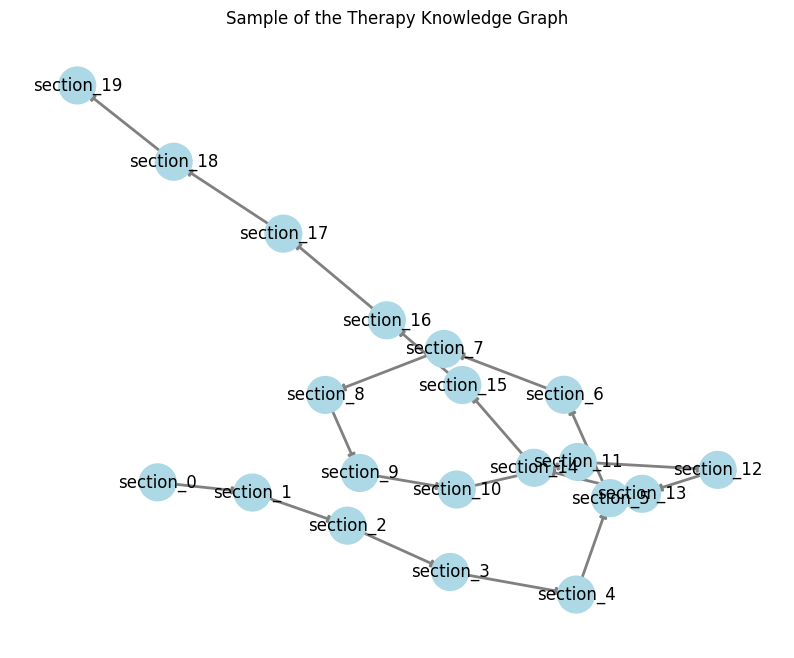


Therapy chatbot setup complete!
You can now interact with the therapy chatbot by calling agent_executor.invoke({'input': 'your question'})

=== Example Interaction ===


> Entering new AgentExecutor chain...
```json
{
    "action": "TherapyResourceRecommendation",
    "action_input": "coping with trauma"
}
```Executing AQL query: 
                FOR node IN TherapyKnowledgeGraph_nodes
                    FILTER node.type == 'section' AND CONTAINS(LOWER(node.text), LOWER(@keyword))
                    RETURN {
                        section_id: node._id,
                        section_text: node.text,
                        section_key: node._key
                    }
                
With bind variables: {'keyword': 'trauma'}
Executing AQL query: 
                FOR node IN TherapyKnowledgeGraph_nodes
                    FILTER node.type == 'section' AND CONTAINS(LOWER(node.text), LOWER(@keyword))
                    RETURN {
                        section_id: node._id,
        

In [21]:
# Main execution function to run the full pipeline
def main(pdf_path):
    print("Starting therapy chatbot setup...")
    print(f"Reading PDF from: {pdf_path}")

    # Step 1-2: Extract data and create NetworkX graph
    graph, section_map = prepare_graph_from_pdf(pdf_path)

    # Check GPU availability
    has_gpu = check_gpu_availability()

    # Step 3: Try to persist to ArangoDB (but continue if not available)
    db, arangodb_adapter = persist_to_arangodb(graph)

    # Visualize a sample of the graph
    print("\nVisualizing a sample of the graph...")
    visualize_graph_sample(graph, sample_size=20)  # Adjust sample_size as needed

    # Create tools
    keyword_search = create_keyword_search_tool(db, section_map)
    entity_search = create_entity_search_tool(db, section_map, graph)
    resource_recommendation = create_resource_recommendation_tool(db, section_map, graph, has_gpu)
    hybrid_search = create_hybrid_query_tool(db, section_map, graph, has_gpu)

    # Create Langchain tools
    tools = [
        Tool(
            name="KeywordSearch",
            func=keyword_search,
            description="Search for therapy information related to a specific keyword or topic"
        ),
        Tool(
            name="EntityRelationshipSearch",
            func=entity_search,
            description="Find information about specific entities (e.g., concepts, therapies, symptoms) and their relationships"
        ),
        Tool(
            name="TherapyResourceRecommendation",
            func=resource_recommendation,
            description="Get therapy resource recommendations based on a description of issues or symptoms"
        ),
        Tool(
            name="ComplexQuestionAnswering",
            func=hybrid_search,
            description="Answer complex therapy-related questions requiring multiple types of information"
        )
    ]

    # Set up the agent with Gemini
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", google_api_key=GEMINI_API_KEY)

    # Create proper chat prompt template
    agent_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a compassionate therapy chatbot designed to provide support and resources for people dealing with violence-related issues.
        You have access to a specialized knowledge base about violence, trauma, and healing resources.

        When interacting with users, maintain a supportive, non-judgmental tone at all times. Prioritize user safety and well-being.
        If someone appears to be in immediate danger, always encourage them to contact emergency services.

        Available Tools:
        {tools}

        Use these tools to provide helpful information and support. When using the tools, be specific about what information you need.

        Tool Names: {tool_names}"""),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    agent_executor = initialize_agent(
        tools=tools,
        llm=llm,
        agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
        verbose=True,
        handle_parsing_errors=True
    )

    print("\nTherapy chatbot setup complete!")
    print("You can now interact with the therapy chatbot by calling agent_executor.invoke({'input': 'your question'})")

    return agent_executor, graph, section_map, db

from langchain_core.messages import HumanMessage, AIMessage

if __name__ == "__main__":
    pdf_path = "/content/Harmonia.pdf"
    result = main(pdf_path)

    if result is None:
        print("Failed to initialize the chatbot. Please check the logs for errors.")
    else:
        agent_executor, graph, section_map, db = result

        # Example interaction
        print("\n=== Example Interaction ===")
        response = agent_executor.invoke({
            "input": "What resources do you have for coping with trauma?",
            "chat_history": []  # Initialize with an empty list
        })
        print(f"Response: {response['output']}")

        # Interactive mode
        print("\n=== Interactive Mode ===")
        print("Type 'exit' to quit")

        chat_history = []  # Initialize chat history as an empty list

        while True:
            user_input = input("\nYour question: ")
            if user_input.lower() == 'exit':
                break

            # Format the chat history as a list of message objects
            formatted_chat_history = []
            for user_msg, ai_msg in chat_history:
                formatted_chat_history.append(HumanMessage(content=user_msg))
                formatted_chat_history.append(AIMessage(content=ai_msg))

            # Invoke the agent with the formatted chat history
            response = agent_executor.invoke({
                "input": user_input,
                "chat_history": formatted_chat_history
            })

            # Update the chat history with the new interaction
            chat_history.append((user_input, response["output"]))
            print(f"\nResponse: {response['output']}")